This notebook contains results and experiments with C-SWM

## Number of objects
Train parameters
- Batch size = 512
- Encoder = Large
- Hidden dim = 512
- Embedding dim = 10
- Num_objects = ?
- Epochs = 10 and 20
- Learning rate 5e-4

Evaluation parameters:
- Linear: 2000 iterations
- Fine tuning 30 and 60 epochs
- 10% of MNIST train labels
- Use transition model or not
- Ranking metrics 1,5 and 10 steps

How to visualize the results: Isolate result curves for each of the evaluation parameters. 

*We are testing for different number of epochs to evaluate correlation between variables and to check if we can get significant results with fewer epochs.

How to evaluate quantitatively => Pearson correlation

In [159]:
import ast
import torch
from torch import tensor
import copy
import numpy as np
    
'''
Function that extracts results from the results file.
Results contain the results for specific experiments for specific parameters, encoded in a dict
Return: result_list{sub_dict['experiment']: result, [param]: value}
The order of the params matters
'''
def extract_results(file_path):
    file_list = []
    with open(file_path, "r") as f:
        for line in f:
            file_list.append(line[:-1])
    
    result_list = []
    i = -1
    temp_dict = None
    while i < len(file_list)-1:
        i += 1
        if len(file_list[i]) == 0:
            continue
        elif file_list[i][0:4] == '----':
            continue
        elif file_list[i][0] == '{':
            if not temp_dict is None:
                result_list.append(temp_dict)
            #Get train parameters
            temp_dict = eval(file_list[i])
        elif file_list[i][0:15] == "use_trans_model":
            #Get if uses trans model and add to dict
            temp_dict['use_trans_model'] = file_list[i].split("=")[1]
        elif file_list[i][0:9] == 'num_steps':
            num_steps = file_list[i].split('=')[1]
            i += 2
            res_steps_dict = eval(file_list[i])
            temp_dict['H1_num_steps='+str(num_steps)] = res_steps_dict['H1']
            temp_dict['MRR_num_steps='+str(num_steps)] = res_steps_dict['MRR'].item()
        else:
            split_line = file_list[i].split(" = ")
            temp_dict[split_line[0]] = float(split_line[1])

    return result_list

'''
Convert dict to a param key
'''
def dict_to_key(dict_target, varying_param, experiment_keys):
    dict_copy = copy.deepcopy(dict_target)
    del dict_copy[varying_param]
    for exp_key in experiment_keys:
        if exp_key in dict_copy:
            del dict_copy[exp_key]
    return str(dict_copy)

'''
Initializes the dictionary for certain parameters
'''
def init_result_dict(experiment_keys, varying_param):
    result_dict = {}
    for exp_key in experiment_keys:
        result_dict[exp_key] = {"result": [], varying_param: []}
    return result_dict

'''
Extracts results arrays for a specific varying param, one for each pair of fixed params and experiment
varying_param => Parameter that is being altered at every iteration
experiments_keys => dict keys that are the experiments
keys that are not experiment or varying are considered fixed
Returns a dictionary(fixed parameters) of dictionary(experiments) of lists(results) + list(varying_param_value)
'''
def get_results_array(result_list, varying_param, experiment_keys):
    final_dict = {}
    for result_dict in result_list:
        param_key = dict_to_key(result_dict, varying_param, experiment_keys)
        if not param_key in final_dict:
            final_dict[param_key] = init_result_dict(experiment_keys, varying_param)
        for exp_key in experiment_keys:
            if exp_key in result_dict:
                final_dict[param_key][exp_key][varying_param].append(result_dict[varying_param])
                final_dict[param_key][exp_key]['result'].append(result_dict[exp_key])
    return final_dict

'''
Uses a list of parameters to return the key to a result dictionary for certain parameters values
Warns if there is a duplicate
'''
def get_param_key(params, values, results):
    found = False
    found_key = None
    for key in results.keys():
        key_dict = eval(key)
        hits = 0
        for param, value in zip(params, values):
            if key_dict[param] == value:
                hits += 1
        if hits == len(params):
            if found == True:
                print("Duplicate")
                print(found_key)
                print(key)
                return None
            found = True
            found_key = key
    return found_key

'''
Processes two lists (x, y), given mean and std dev values
Returns 3 lists: x , y_mean, y_std_dev
'''
def get_mean_std_dev(xs, ys):
    #use np
    aux_dict = {}
    for x,y in zip(xs, ys):
        if not x in aux_dict:
            aux_dict[x] = []
        aux_dict[x].append(y)

    x_out = []
    y_mean = []
    y_std = []
    for x in aux_dict.keys():
        x_out.append(x)
        y_mean.append(np.asarray(aux_dict[x]).mean())
        y_std.append(np.asarray(aux_dict[x]).std())
    return x_out, y_mean, y_std

'''
Function to simplify plotting pipeline
'''
def get_plot_ready_res(results, params, values, experiment_key, varying_param):
    found_key = get_param_key(params, values, results)
    x, y_mean, y_std = get_mean_std_dev(results[found_key][experiment_key][varying_param], results[found_key][experiment_key]['result'])
    return x, y_mean, y_std

'''
Generates Pearson Correlation Matrix
Variables(experiments) are in the order given by experiment_keys
'''
def generate_pearson_corr_mat(results, params, values, experiment_keys, varying_param):
    found_key = get_param_key(params, values, results)
    res_matrix = None
    for experiment_key in experiment_keys:
        x, y_mean, y_std = get_mean_std_dev(results[found_key][experiment_key][varying_param], results[found_key][experiment_key]['result'])
        y_mean = np.asarray(y_mean).reshape(1, len(y_mean))
        print(experiment_key, y_mean)
        if res_matrix is None:
            res_matrix = np.asarray(y_mean)
        else:
            res_matrix = np.concatenate((res_matrix, np.asarray(y_mean)), axis=0)
    print(res_matrix)
    return np.corrcoef(res_matrix)

In [114]:
experiment_keys = ['LineaEvalAcc', 'FineTuning10pc30epochs', 'FineTuning10pc60epochs']
experiment_keys += ['H1_num_steps=1', 'H1_num_steps=5', 'H1_num_steps=10']
experiment_keys += ['MRR_num_steps=1', 'MRR_num_steps=5', 'MRR_num_steps=10']
varying_param = 'num_objects'
result_list = extract_results("eval_all_results.txt")
results = get_results_array(result_list, varying_param, experiment_keys)

In [115]:
results

{"{'batch_size': 512, 'epochs': 10, 'learning_rate': 0.0005, 'encoder': 'large', 'sigma': 0.5, 'hinge': 1.0, 'hidden_dim': 512, 'embedding_dim': 10, 'action_dim': 4, 'ignore_action': True, 'copy_action': False, 'decoder': False, 'no_cuda': False, 'seed': 42, 'log_interval': 20, 'dataset': '/datasets/c_swm_data/mmnist_train.h5', 'name': 'mmnist', 'save_folder': 'checkpoints', 'cuda': True, 'use_trans_model': 'False'}": {'LinearEvalAcc': {'result': [0.2847,
    0.3899,
    0.4188,
    0.6198,
    0.5059,
    0.4684,
    0.3448,
    0.4264,
    0.5237,
    0.5467,
    0.4855,
    0.4742],
   'num_objects': [2, 5, 10, 15, 20, 25, 2, 5, 10, 15, 20, 25]},
  'FineTuning10pc30epochs': {'result': [0.3338,
    0.806,
    0.71,
    0.7735,
    0.8768,
    0.762,
    0.2584,
    0.5726,
    0.7876,
    0.8023,
    0.8552,
    0.8372],
   'num_objects': [2, 5, 10, 15, 20, 25, 2, 5, 10, 15, 20, 25]},
  'FineTuning10pc60epochs': {'result': [0.5989,
    0.898,
    0.8859,
    0.9071,
    0.9264,
    0

<ErrorbarContainer object of 3 artists>

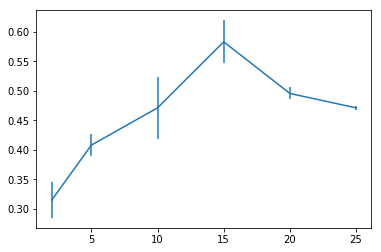

In [141]:
import matplotlib.pyplot as plt
params = ['epochs', 'use_trans_model']
values = [10, 'False']
experiment_key = 'LinearEvalAcc'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std)

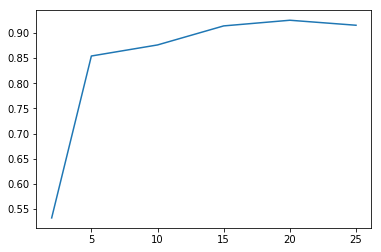

In [126]:
params = ['epochs', 'use_trans_model']
values = [10, 'False']
experiment_key = 'FineTuning10pc60epochs'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.plot(x, y_mean)

<ErrorbarContainer object of 3 artists>

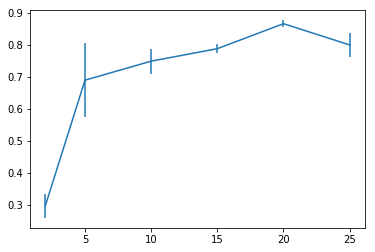

In [140]:
params = ['epochs', 'use_trans_model']
values = [10, 'False']
experiment_key = 'FineTuning10pc30epochs'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std)

<ErrorbarContainer object of 3 artists>

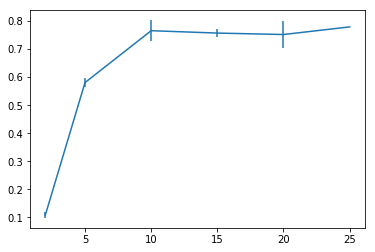

In [139]:
params = ['epochs', 'use_trans_model']
values = [20, 'True']
experiment_key = 'H1_num_steps=5'
varying_param = 'num_objects'
x, y_mean, y_std = get_plot_ready_res(results, params, values, experiment_key, varying_param)
plt.errorbar(x, y_mean, yerr=y_std)

In [167]:
params = ['epochs', 'use_trans_model']
values = [10, 'True']
experiment_keys = ['LinearEvalAcc', 'FineTuning10pc30epochs', 'FineTuning10pc60epochs', 'H1_num_steps=1']
varying_param = 'num_objects'
generate_pearson_corr_mat(results, params, values, experiment_keys, varying_param)

LinearEvalAcc [[0.35605 0.4145  0.4738  0.56465 0.4743  0.47875]]
FineTuning10pc30epochs [[0.4239  0.7083  0.71175 0.82255 0.8083  0.84005]]
FineTuning10pc60epochs [[0.44935 0.8339  0.86595 0.8924  0.8294  0.90595]]
H1_num_steps=1 [[0.829    0.968125 0.976125 0.983375 0.98125  0.983625]]
[[0.35605  0.4145   0.4738   0.56465  0.4743   0.47875 ]
 [0.4239   0.7083   0.71175  0.82255  0.8083   0.84005 ]
 [0.44935  0.8339   0.86595  0.8924   0.8294   0.90595 ]
 [0.829    0.968125 0.976125 0.983375 0.98125  0.983625]]


array([[1.        , 0.83479954, 0.79166506, 0.77595982],
       [0.83479954, 1.        , 0.95233348, 0.95854749],
       [0.79166506, 0.95233348, 1.        , 0.99044186],
       [0.77595982, 0.95854749, 0.99044186, 1.        ]])